In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint


In [12]:
import os
import cv2
import numpy as np

# Directory paths
directory_path1 = 'Downloads/AI IMAGES'
directory_path2 = 'Downloads/REAL (1)'

# Function to load and preprocess images from a directory in batches
def image_generator(directory_path, batch_size=32):
    files = os.listdir(directory_path)
    while True:
        np.random.shuffle(files)
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_images = []
            for file in batch_files:
                file_path = os.path.join(directory_path, file)
                try:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                        image = cv2.imread(file_path)
                        if image is not None:
                            image = cv2.resize(image, (128, 128))  # Adjust size as needed
                            image = image.astype(np.float32) / 255.0
                            batch_images.append(image)
                        else:
                            print(f"Error reading image: {file_path}. Skipping.")
                except Exception as e:
                    print(f"Error processing image: {file_path}. {str(e)}. Skipping.")
            yield np.array(batch_images)

# Example usage of the generators directly in the training loop
batch_size = 32
generator1 = image_generator(directory_path1, batch_size=batch_size)
generator2 = image_generator(directory_path2, batch_size=batch_size)

# Number of batches to process (adjust as needed)
num_batches = 50  # Limiting to 50 batches

# Initialize combined dataset
combined_dataset = np.zeros((0, 128, 128, 3), dtype=np.float32)

# Load and preprocess images from both directories in limited batches during training
for _ in range(num_batches):
    batch_dataset1 = next(generator1)
    batch_dataset2 = next(generator2)
    
    combined_batch = np.concatenate((batch_dataset1, batch_dataset2), axis=0)
    np.random.shuffle(combined_batch)
    
    combined_dataset = np.concatenate((combined_dataset, combined_batch), axis=0)


In [13]:
# Generator
def create_generator():
    model = Sequential(name="Generator")
    n_nodes = 16 * 16 * 512
    model.add(Dense(n_nodes, input_shape=(100,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))
    return model


In [14]:
# Discriminator
def create_discriminator():
    model = Sequential(name="Discriminator")
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))
    model.add(Flatten(name='Discriminator-Flatten-Layer'))
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout'))
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer'))
    return model

In [15]:
# Define the generator and discriminator
generator = create_generator()
discriminator = create_discriminator()

In [16]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (  (None, 131072)            13238272  
 Dense)                                                          
                                                                 
 Generator-Hidden-Layer-Res  (None, 16, 16, 512)       0         
 hape-1 (Reshape)                                                
                                                                 
 Generator-Hidden-Layer-2 (  (None, 32, 32, 256)       1179904   
 Conv2DTranspose)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 Generator-Hidden-Layer-3 (  (None, 64, 64, 128)       295040    
 Conv2DTranspose)                                        

In [17]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      896       
 -1 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 128, 128, 32)      0         
 -Activation-1 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)        18496     
 -2 (Conv2D)                                                     
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 Discriminator-Hidden-Layer  (None, 64, 64, 64)      

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [20]:
# Define a seed for generating consistent results
seed = tf.random.normal([16, 100])

In [21]:
def create_or_load_models():
    generator = create_generator()
    discriminator = create_discriminator()

    # Check if there are saved weights for generator and discriminator
    if os.path.exists("generator_weights2.h5"):
        generator.load_weights("generator_weights2.h5")
        print("Generator weights loaded.")
    if os.path.exists("discriminator_weights2.h5"):
        discriminator.load_weights("discriminator_weights2.h5")
        print("Discriminator weights loaded.")

    return generator, discriminator


In [31]:

# Training loopfrom tensorflow.keras.callbacks import ModelCheckpoint

# Training function with model checkpoint callback
def train(dataset, epochs, batch_size):
    # Create or load the generator and discriminator models
    generator, discriminator = create_or_load_models()

    # Specify the path where you want to save the models
    checkpoint_path = "model_checkpoints/model_epoch_{epoch:02d}.h5"

    # Create a ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',  # You can choose the metric to monitor
        save_best_only=False,  # Save all models, not just the best one
        save_weights_only=True,  # Save only the weights, not the entire model
        mode='auto',  # Automatically decide to save based on the monitored metric
        save_freq='epoch'  # Save the model weights after each epoch
    )

    # Set up loss and optimizer
    cross_entropy = BinaryCrossentropy(from_logits=False)
    discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    # Compile the models
    generator.compile(loss=generator_loss, optimizer=generator_optimizer)
    discriminator.compile(loss=discriminator_loss, optimizer=discriminator_optimizer)

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")

        # Variables to track losses
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        for real_images in dataset:
            noise = tf.random.normal([batch_size, 100])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            # Update average losses
            gen_loss_avg(gen_loss)
            disc_loss_avg(disc_loss)

        # Print average losses at the end of each epoch
        print(f"Generator Loss: {gen_loss_avg.result().numpy()}, Discriminator Loss: {disc_loss_avg.result().numpy()}")

        # Save losses for later printing
        generator_losses.append(gen_loss_avg.result().numpy())
        discriminator_losses.append(disc_loss_avg.result().numpy())

        # Generate and save sample images at the end of each epoch
        if (epoch) % 10 == 0:
            generate_and_save_images(generator, epoch, seed)

        # Save models at checkpoints
        if (epoch) % 5 == 0:
            generator.save_weights(f'generator_weights2.h5')
            discriminator.save_weights(f'discriminator_weights2.h5')
        if if (epoch)  == 151:
            generate_and_save_images(generator, epoch, seed)
 			generator.save_weights(f'generator_weights2.h5')
            discriminator.save_weights(f'discriminator_weights2.h5')
    # Print only the final losses
    print("Final Generator Loss:", generator_losses[-1])
    print("Final Discriminator Loss:", discriminator_losses[-1])


In [32]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    predictions = (predictions + 1) / 2.0

    # Create the 'generated_images' directory if it doesn't exist
    if not os.path.exists('generated_images2'):
        os.makedirs('generated_images2')

    # Plot the generated images
    fig, axes = plt.subplots(4,4, figsize=(4, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(predictions[i])
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_images/generated_image_epoch_{epoch}.png')
    plt.show()

Epoch 0/100
Generator Loss: 6.638004779815674, Discriminator Loss: 0.6846591830253601


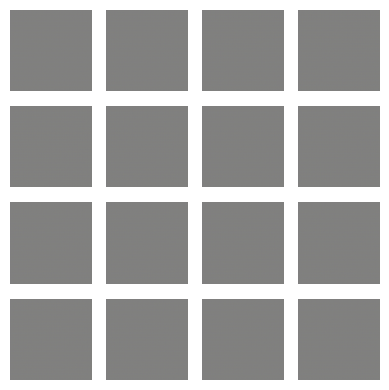

Epoch 1/100
Generator Loss: 13.463841438293457, Discriminator Loss: 1.1358611583709717
Epoch 2/100
Generator Loss: 6.889740467071533, Discriminator Loss: 0.7459864616394043
Epoch 3/100
Generator Loss: 4.509028434753418, Discriminator Loss: 0.08450978249311447
Epoch 4/100
Generator Loss: 6.230505466461182, Discriminator Loss: 0.4964715540409088
Epoch 5/100
Generator Loss: 4.422300815582275, Discriminator Loss: 0.06477601081132889
Epoch 6/100
Generator Loss: 5.369219779968262, Discriminator Loss: 0.36776572465896606
Epoch 7/100
Generator Loss: 4.166329860687256, Discriminator Loss: 0.3749150037765503
Epoch 8/100
Generator Loss: 4.920214653015137, Discriminator Loss: 0.643329918384552
Epoch 9/100
Generator Loss: 3.488906145095825, Discriminator Loss: 0.47531989216804504
Epoch 10/100
Generator Loss: 4.649777412414551, Discriminator Loss: 0.5232002139091492


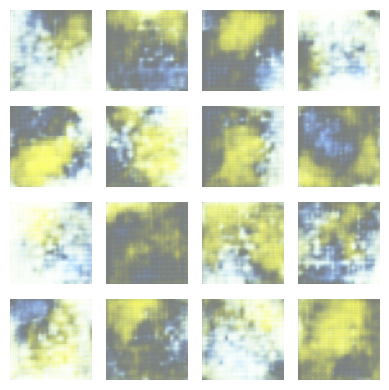

Epoch 11/100
Generator Loss: 3.968031644821167, Discriminator Loss: 0.39326366782188416
Epoch 12/100
Generator Loss: 3.892273187637329, Discriminator Loss: 0.656125009059906
Epoch 13/100
Generator Loss: 4.352039813995361, Discriminator Loss: 0.701490581035614
Epoch 14/100
Generator Loss: 4.2695841789245605, Discriminator Loss: 0.45981472730636597
Epoch 15/100
Generator Loss: 4.260866641998291, Discriminator Loss: 0.594709575176239
Epoch 16/100
Generator Loss: 3.9965603351593018, Discriminator Loss: 0.5531975030899048
Epoch 17/100
Generator Loss: 3.2414450645446777, Discriminator Loss: 0.7541703581809998
Epoch 18/100
Generator Loss: 3.3662350177764893, Discriminator Loss: 0.7873449921607971
Epoch 19/100
Generator Loss: 3.1554572582244873, Discriminator Loss: 0.9212172031402588
Epoch 20/100
Generator Loss: 2.8640036582946777, Discriminator Loss: 0.7529317736625671


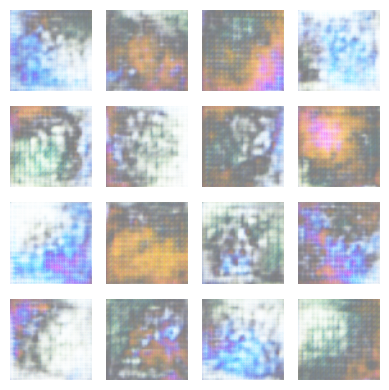

Epoch 21/100
Generator Loss: 2.6667895317077637, Discriminator Loss: 0.8478958606719971
Epoch 22/100
Generator Loss: 2.6830615997314453, Discriminator Loss: 0.7284902334213257
Epoch 23/100
Generator Loss: 2.803273916244507, Discriminator Loss: 0.7640094757080078
Epoch 24/100
Generator Loss: 3.0970568656921387, Discriminator Loss: 0.7302391529083252
Epoch 25/100
Generator Loss: 2.4316327571868896, Discriminator Loss: 0.8103640675544739
Epoch 26/100
Generator Loss: 2.5115044116973877, Discriminator Loss: 0.7721261382102966
Epoch 27/100
Generator Loss: 2.519531488418579, Discriminator Loss: 0.8985893130302429
Epoch 28/100
Generator Loss: 2.6537671089172363, Discriminator Loss: 0.8809123039245605
Epoch 29/100
Generator Loss: 2.714345932006836, Discriminator Loss: 0.7969166040420532
Epoch 30/100
Generator Loss: 2.7221853733062744, Discriminator Loss: 0.7255760431289673


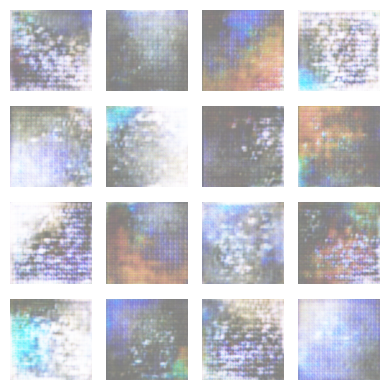

Epoch 31/100
Generator Loss: 2.6048290729522705, Discriminator Loss: 0.8416481018066406
Epoch 32/100
Generator Loss: 2.923441171646118, Discriminator Loss: 0.8790957927703857
Epoch 33/100
Generator Loss: 2.4465091228485107, Discriminator Loss: 0.8944107890129089
Epoch 34/100
Generator Loss: 2.2446908950805664, Discriminator Loss: 0.955433189868927
Epoch 35/100
Generator Loss: 2.2773427963256836, Discriminator Loss: 0.9460075497627258
Epoch 36/100
Generator Loss: 2.098520040512085, Discriminator Loss: 0.950002908706665
Epoch 37/100
Generator Loss: 2.0636768341064453, Discriminator Loss: 1.0546767711639404
Epoch 38/100
Generator Loss: 1.9166784286499023, Discriminator Loss: 1.0578041076660156
Epoch 39/100
Generator Loss: 1.9815410375595093, Discriminator Loss: 1.0470532178878784
Epoch 40/100
Generator Loss: 2.114595651626587, Discriminator Loss: 1.0716629028320312


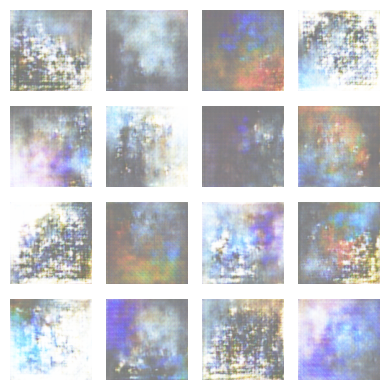

Epoch 41/100
Generator Loss: 1.9017192125320435, Discriminator Loss: 1.0976340770721436
Epoch 42/100
Generator Loss: 2.017404317855835, Discriminator Loss: 0.9252476692199707
Epoch 43/100
Generator Loss: 1.96759831905365, Discriminator Loss: 1.020295262336731
Epoch 44/100
Generator Loss: 1.934058666229248, Discriminator Loss: 0.9485952258110046
Epoch 45/100
Generator Loss: 2.0482470989227295, Discriminator Loss: 0.9137699604034424
Epoch 46/100
Generator Loss: 2.0956647396087646, Discriminator Loss: 0.9335671067237854
Epoch 47/100
Generator Loss: 2.120278835296631, Discriminator Loss: 0.8961416482925415
Epoch 48/100
Generator Loss: 2.073537826538086, Discriminator Loss: 0.8117857575416565
Epoch 49/100
Generator Loss: 2.13716721534729, Discriminator Loss: 0.8734548687934875
Epoch 50/100
Generator Loss: 2.243694305419922, Discriminator Loss: 0.698512852191925


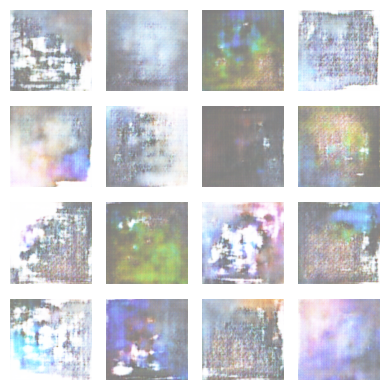

Epoch 51/100
Generator Loss: 2.343881607055664, Discriminator Loss: 0.6580197215080261
Epoch 52/100
Generator Loss: 2.5106513500213623, Discriminator Loss: 0.8068076968193054
Epoch 53/100
Generator Loss: 2.3031210899353027, Discriminator Loss: 0.597281813621521
Epoch 54/100
Generator Loss: 2.517376184463501, Discriminator Loss: 0.6603227257728577
Epoch 55/100
Generator Loss: 2.421799898147583, Discriminator Loss: 0.6049721837043762
Epoch 56/100
Generator Loss: 2.6451077461242676, Discriminator Loss: 0.6218141317367554
Epoch 57/100
Generator Loss: 2.6608710289001465, Discriminator Loss: 0.5149914622306824
Epoch 58/100
Generator Loss: 3.02519154548645, Discriminator Loss: 0.6301932334899902
Epoch 59/100
Generator Loss: 2.630722999572754, Discriminator Loss: 0.6883416175842285
Epoch 60/100
Generator Loss: 2.583601474761963, Discriminator Loss: 0.5522153973579407


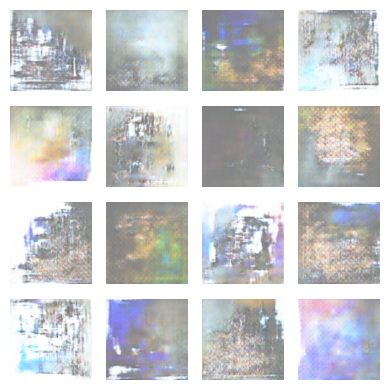

Epoch 61/100
Generator Loss: 2.820324182510376, Discriminator Loss: 0.5318772196769714
Epoch 62/100
Generator Loss: 2.7907721996307373, Discriminator Loss: 0.6323730945587158
Epoch 63/100
Generator Loss: 2.7326157093048096, Discriminator Loss: 0.5602043867111206
Epoch 64/100
Generator Loss: 2.973788261413574, Discriminator Loss: 0.8944519758224487
Epoch 65/100
Generator Loss: 2.7294411659240723, Discriminator Loss: 0.6726106405258179
Epoch 66/100
Generator Loss: 2.5878689289093018, Discriminator Loss: 0.5482271909713745
Epoch 67/100
Generator Loss: 2.6378374099731445, Discriminator Loss: 0.5174762606620789
Epoch 68/100
Generator Loss: 2.7968060970306396, Discriminator Loss: 0.538987934589386
Epoch 69/100
Generator Loss: 2.8692986965179443, Discriminator Loss: 0.6208879947662354
Epoch 70/100
Generator Loss: 2.7758188247680664, Discriminator Loss: 0.5503867268562317


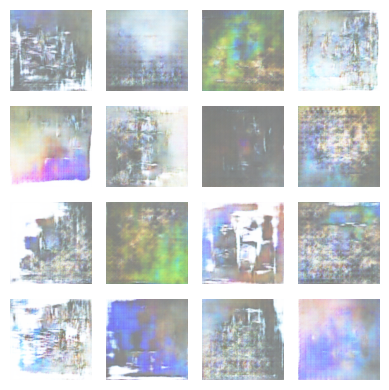

Epoch 71/100
Generator Loss: 2.7377583980560303, Discriminator Loss: 0.540962815284729
Epoch 72/100
Generator Loss: 2.9226715564727783, Discriminator Loss: 0.5591583847999573
Epoch 73/100
Generator Loss: 2.9642865657806396, Discriminator Loss: 0.881388783454895
Epoch 74/100
Generator Loss: 2.7420578002929688, Discriminator Loss: 0.6909390091896057
Epoch 75/100
Generator Loss: 2.6154520511627197, Discriminator Loss: 0.5599085688591003
Epoch 76/100
Generator Loss: 2.797961711883545, Discriminator Loss: 0.4767224192619324
Epoch 77/100
Generator Loss: 2.9024972915649414, Discriminator Loss: 0.5157201886177063
Epoch 78/100
Generator Loss: 2.832878351211548, Discriminator Loss: 0.5802556872367859
Epoch 79/100
Generator Loss: 2.919271945953369, Discriminator Loss: 0.7235691547393799
Epoch 80/100
Generator Loss: 2.9815196990966797, Discriminator Loss: 0.5880473852157593


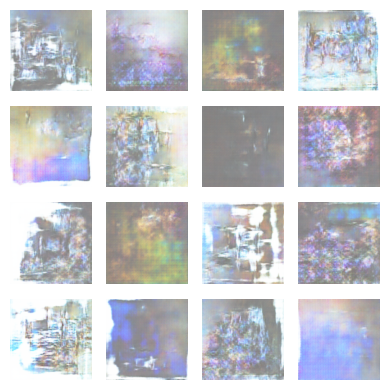

Epoch 81/100
Generator Loss: 2.8497867584228516, Discriminator Loss: 0.47329509258270264
Epoch 82/100
Generator Loss: 3.1651253700256348, Discriminator Loss: 0.6538646817207336
Epoch 83/100
Generator Loss: 3.0219204425811768, Discriminator Loss: 0.4454119801521301
Epoch 84/100
Generator Loss: 3.0850818157196045, Discriminator Loss: 0.8303127288818359
Epoch 85/100
Generator Loss: 2.9895389080047607, Discriminator Loss: 0.6141963005065918
Epoch 86/100
Generator Loss: 2.991753339767456, Discriminator Loss: 0.48058322072029114
Epoch 87/100
Generator Loss: 3.1292035579681396, Discriminator Loss: 0.48979759216308594
Epoch 88/100
Generator Loss: 3.1716256141662598, Discriminator Loss: 0.5448415279388428
Epoch 89/100
Generator Loss: 3.0292935371398926, Discriminator Loss: 0.6034867763519287
Epoch 90/100
Generator Loss: 3.2473068237304688, Discriminator Loss: 0.4343295991420746


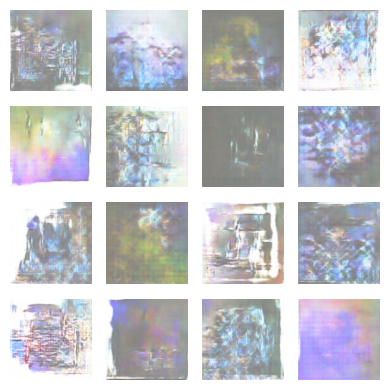

Epoch 91/100
Generator Loss: 3.2171807289123535, Discriminator Loss: 0.5142257809638977
Epoch 92/100
Generator Loss: 3.2264537811279297, Discriminator Loss: 0.5880331993103027
Epoch 93/100
Generator Loss: 3.4383468627929688, Discriminator Loss: 0.5141435861587524
Epoch 94/100
Generator Loss: 3.1195991039276123, Discriminator Loss: 0.37973538041114807
Epoch 95/100
Generator Loss: 3.3738651275634766, Discriminator Loss: 0.5730863809585571
Epoch 96/100
Generator Loss: 3.3093929290771484, Discriminator Loss: 0.3465890884399414
Epoch 97/100
Generator Loss: 3.3855602741241455, Discriminator Loss: 0.9121858477592468
Epoch 98/100
Generator Loss: 3.170421838760376, Discriminator Loss: 0.4874619245529175
Epoch 99/100
Generator Loss: 3.36222505569458, Discriminator Loss: 0.5996286273002625
Final Generator Loss: 3.362225
Final Discriminator Loss: 0.5996286


In [33]:
# Example usage
batch_size = 64
epochs = 151
generator_losses = []
discriminator_losses = []
resized_dataset = tf.image.resize(combined_dataset, size=(256, 256))
# Assuming you have a combined_dataset variable with preprocessed images
train_dataset = tf.data.Dataset.from_tensor_slices(resized_dataset).shuffle(len(resized_dataset)).batch(batch_size)

# Train the model
train(train_dataset, epochs, batch_size)